In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics


In [11]:
#import the dataset from GitHub
#url = 'https://raw.githubusercontent.com/jamesdinardo/Retail-Forecasting/master/final_df.csv'
url = 'C:/Users/User/Desktop/Data_science/retail/final_df.csv'
df = pd.read_csv(url)

In [12]:
print('Shape of final dataframe: {}'.format(df.shape))
df.head()

Shape of final dataframe: (421570, 16)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Type,Size,Weekly_Sales
0,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,A,151315,24924.50
1,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,A,151315,50605.27
2,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,3,A,151315,13740.12
3,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,4,A,151315,39954.04
4,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5,A,151315,32229.38


In [13]:
#convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

#convert Store, Dept, and Type columns to category
df['Store'] = df['Store'].astype('category')

df['Dept'] = df['Dept'].astype('category')

df['Type'] = df['Type'].astype('category')

In [14]:
#create separate features for Week, Month, and Year
df['Month'] = df['Date'].dt.month
df['Month'] = df['Month'].astype('category')

df['Week'] = df['Date'].dt.week
df['Week'] = df['Week'].astype('category')

df['Year'] = df['Date'].dt.year
df['Year'] = df['Year'].astype('category')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  category      
 1   Date          421570 non-null  datetime64[ns]
 2   Temperature   421570 non-null  float64       
 3   Fuel_Price    421570 non-null  float64       
 4   MarkDown1     421570 non-null  float64       
 5   MarkDown2     421570 non-null  float64       
 6   MarkDown3     421570 non-null  float64       
 7   MarkDown4     421570 non-null  float64       
 8   MarkDown5     421570 non-null  float64       
 9   CPI           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  IsHoliday     421570 non-null  bool          
 12  Dept          421570 non-null  category      
 13  Type          421570 non-null  category      
 14  Size          421570 non-null  int64         
 15  Weekly_Sales  421

In [16]:
df.drop('Date', axis=1, inplace=True)

In [17]:
#create dummy variables
df_dummies = pd.get_dummies(df)

In [18]:
X = df_dummies.drop('Weekly_Sales', axis=1).values
y = df_dummies['Weekly_Sales'].values.reshape(-1, 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [20]:
dt = DecisionTreeRegressor(random_state=0)

In [21]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [22]:
y_pred = dt.predict(X_test)

print('R2 with default parameters: {}'.format(dt.score(X_test, y_test)))
print('RMSE with default parameters: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

R2 with default parameters: 0.9545942732178108
RMSE with default parameters: 4869.624488107791


In [23]:
#Create a decision tree with max depth of 4 for plotting
dt_pruned = DecisionTreeRegressor(random_state=0, max_depth=4)
dt_pruned.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=4, random_state=0)

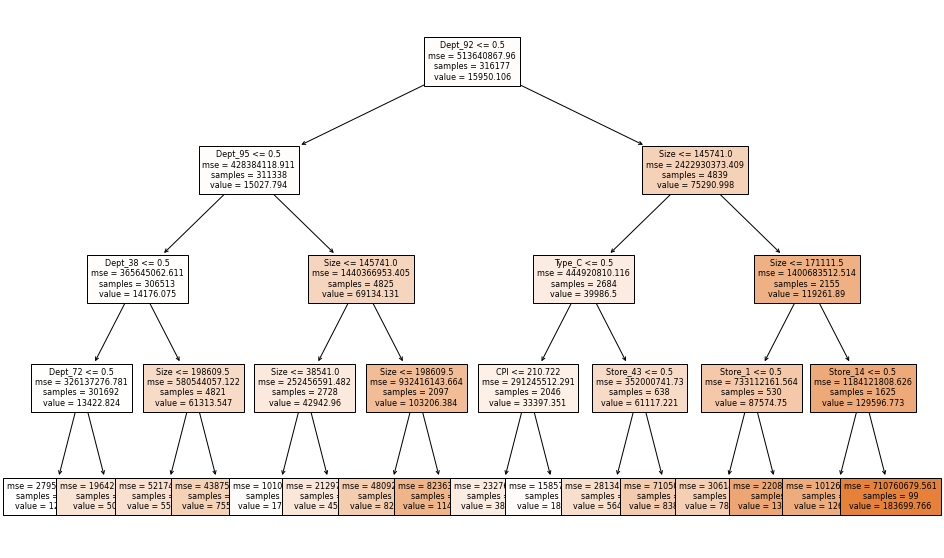

In [30]:
#plot the tree
features = list(df_dummies.drop('Weekly_Sales', axis=1).columns)

fig, ax = plt.subplots(figsize=(16,10))
tree.plot_tree(dt_pruned, feature_names=features, fontsize=8, filled=True)
plt.show()

From this it looks like the department and size are the biggest predictors of sales. We can also take a look at the feature importances:

In [211]:
#calculate feature importances
pd.DataFrame({'Feature': features, 'Feature Importance':dt.feature_importances_}).sort_values(by='Feature Importance', ascending=False).head(15)


,Feature,Feature Importance
10,Size,0.178186
129,Dept_92,0.106555
132,Dept_95,0.088346
92,Dept_38,0.067014
127,Dept_90,0.045742
116,Dept_72,0.039519
94,Dept_40,0.034930
57,Dept_2,0.034021
128,Dept_91,0.025005
131,Dept_94,0.020199


Next, let's try out a few different hyperparameter values for max_depth, max_leaf_nodes, and min_sample_split

In [148]:
#iterate over different values for max_depth
md_values = np.array([4, 10, 20, 30, 40, None])

for i in md_values:
    dt = DecisionTreeRegressor(random_state=0, max_depth=i)
    dt.fit(X_train, y_train)
    print('Max Depth of {}: {}'.format(i, dt.score(X_test, y_test)))

Max Depth of 32: 0.9189616872006777
Max Depth of 34: 0.9293882930001949
Max Depth of 36: 0.9332763556065248
Max Depth of 38: 0.9375707224853156
Max Depth of 40: 0.9404796054768985
Max Depth of None: 0.9545942732178108


In [150]:
#iterate over different possible max leaf node values and see which performs best
ml_values = np.array([5, 10, 15, 20, 25, 30, 35, None])
for i in ml_values:
    dt = DecisionTreeRegressor(random_state=0, max_depth=None, max_leaf_nodes=i)
    dt.fit(X_train, y_train)
    print('Max leaf nodes = {}: {}'.format(i, dt.score(X_test, y_test)))
                    

Max leave nodes = 5: 0.307297140766853
Max leave nodes = 10: 0.46487416838733986
Max leave nodes = 15: 0.5539140350839645
Max leave nodes = 20: 0.6071091645250702
Max leave nodes = 25: 0.6336019416486132
Max leave nodes = 30: 0.6553096204210411
Max leave nodes = 35: 0.6748294313485337
Max leave nodes = None: 0.9545942732178108


In [156]:
#iterate over different possible min_sample_split and see which performs best
ms_values = np.array([0.001, 0.01, 0.1, .2, .3, .4])
for i in ms_values:
    dt = DecisionTreeRegressor(random_state=0, max_depth=None, min_samples_split=i)
    dt.fit(X_train, y_train)
    print('Min sample split = {}: {}'.format(i, dt.score(X_test, y_test)))
                    

Min sample split = 0.001: 0.9351715056622174
Min sample split = 0.01: 0.7816788785065419
Min sample split = 0.1: 0.6402654594520063
Min sample split = 0.2: 0.6263513508234164
Min sample split = 0.3: 0.5425444300703892
Min sample split = 0.4: 0.362428465182999


The default values for max_depth, max_leaf_nodes, and min_sample_split are best. In other words, setting any limit to how deep the tree can be, how many leaf nodes there can be, and the minimum number of samples that must be in each node, results in a worse model performance.

Instead of splitting the train and test data randomly, we can train only on data from 2010-2011, and test (make predictions) for 2012

In [158]:
#split into train test based on year
X_train = df_dummies.loc[(df['Year']==2010) | (df['Year']==2011), :].drop('Weekly_Sales', axis=1).values
X_test = df_dummies.loc[df['Year']==2012, :].drop('Weekly_Sales', axis=1).values
y_train = df_dummies.loc[(df['Year']==2010) | (df['Year']==2011), 'Weekly_Sales'].values.reshape(-1, 1)
y_test = df_dummies.loc[df['Year']==2012, 'Weekly_Sales'].values.reshape(-1, 1)

print(X_train.shape)
print(X_test.shape)

(294132, 207)
(127438, 207)


In [159]:
dt = DecisionTreeRegressor(random_state=0)

In [160]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [161]:
y_pred = dt.predict(X_test)

print('R2 with default parameters: {}'.format(dt.score(X_test, y_test)))
print('RMSE with default parameters: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

R2 with default parameters: 0.8774778106289113
RMSE with default parameters: 7742.860913568441


In [162]:
#iterate over different values for max_depth
md_values = np.array([4, 10, 20, 30, 40, None])

for i in md_values:
    dt = DecisionTreeRegressor(random_state=0, max_depth=i)
    dt.fit(X_train, y_train)
    print('Max Depth of {}: {}'.format(i, dt.score(X_test, y_test)))

Max Depth of 4: 0.4175568854510475
Max Depth of 10: 0.6980973301066247
Max Depth of 20: 0.814382138750112
Max Depth of 30: 0.8535839457283416
Max Depth of 40: 0.8700040024612873
Max Depth of None: 0.8774778106289113


Once again, it looks like default parameters are best